In [1]:
%matplotlib inline
import sys
sys.path.append("/Users/edwardlrichards/compAcoustics") 
sys.path.append("/Users/edwardlrichards/swellEx") 

import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib
matplotlib.style.use('ggplot')

import swellEx_env
import loadCSDM as cm
from loadSWellEx_96 import SWellEx as Swell
import datetime as d

import scipy.signal as sp
from normalMode import Chinook

In [2]:
# Experimental data
x_year = str(1996)
startTime = d.datetime(1996,5,10,23,50)
endTime = d.datetime(1996,5,11,0,25)
sensorPosition = swellEx_env.loadArray(reducedIndex = False)

fS = 1500
snapLength = 4  # sec
stepLength = snapLength
timeStep = d.timedelta(0, snapLength)

sD = 67
sourceLevel = 158  # SL
channelIndex = np.array([0,1,2])

In [3]:
# Look at vertical intensity measurements for frequencies of interest
frequencies = np.array([49, 64, 79, 94, 112, 130, 148,\
                        166, 201, 235, 283, 338, 388])
waveLength = 1500 / frequencies
dz = sensorPosition.iloc[0] - sensorPosition.iloc[1]
sensorSpacing = dz / waveLength
frequencies = frequencies[sensorSpacing < 1/8]

In [4]:
def estimatePowerAtF(data, frequencies):
    '''Run a pWelch and return power at frequencies of interest'''
    f, Pxx = sp.welch(data, fs=fS, nperseg=2**11,\
                      scaling='spectrum', axis=0)
    try :
        result = [Pxx[np.argmin(np.abs(f - freq))]\
                  for freq in frequencies]
        actualFreq = [f[np.argmin(np.abs(f - freq))]\
                  for freq in frequencies]
    except TypeError:
        result = Pxx[np.argmin(np.abs(f - frequencies))]
        actualFreq = f[np.argmin(np.abs(f - frequencies))]
        actualFreq = [actualFreq]
        
    result = np.array(result, ndmin=2)
    result = pd.DataFrame(result, index = actualFreq,\
                          columns = data.columns)
    return result

In [5]:
NFFT = np.int(2 ** np.ceil(np.log2(timeStep.seconds * fS)))
f = (np.arange(NFFT / 2 + 1) / NFFT) * fS
freqI = np.array([np.argmin(np.abs(f - freq))\
                  for freq in frequencies])

In [6]:
def caluclateI_z(snapshotData, diffType = 0):
    
    p = snapshotData.mean(axis=1)
    
    if diffType == 1:
        diffCoefficents = np.array((-1, 0, 1))
        fac = 2
    elif diffType == 2:
        diffCoefficents = np.array((-3, 4, -1))
        fac = 2
    elif diffType == 3:
        diffCoefficents = np.array((-1, 1, 0))
        fac = 1
    elif diffType == 4:
        diffCoefficents = np.array((0, -1, 1))
        fac = 1

    v = diffCoefficents * snapshotData 
    v = v.sum(axis=1)
    coefficent = (1 /\
        (fac * dz * 1j * 2 * np.pi * np.array(frequencies) * 1e3))
    v = v * coefficent
    i_z = 1/2 * p * np.conj(v)
    return i_z, p, v

In [7]:
dataLoader = Swell(startTime, endTime)
currentTime = startTime
tForFFT = np.arange(snapLength * fS) / fS

In [8]:
intensity = []
pressure = []
velocity = []
tMeasure = []
for _ in np.arange((endTime - startTime).seconds / snapLength):
    acousticData = dataLoader(currentTime,\
        currentTime + timeStep, channelIndex)
    acousticData.index = tForFFT
    
    p_FT = cm.xFormData(acousticData)
    snapP = p_FT.iloc[freqI]
    
    (i_z, p, v) = caluclateI_z(snapP, diffType = 2)
        
    intensity.append(i_z)
    pressure.append(p)
    velocity.append(v)
    tMeasure.append(currentTime)
    currentTime += timeStep
    
intensity = pd.DataFrame(np.array(intensity), index = tMeasure,\
                        columns = frequencies)
pressure = pd.DataFrame(np.array(pressure), index = tMeasure,\
                        columns = frequencies)
velocity = pd.DataFrame(np.array(velocity), index = tMeasure,\
                        columns = frequencies)

In [9]:
# Measured range series
timeStamp = np.array([startTime + d.timedelta(0, dt) for\
        dt in np.array(np.arange(velocity.shape[0]) * stepLength, dtype = float)])
rangeMeasure = swellEx_env.rangeSeries.asof(timeStamp)
uniqueRange, uniqueIndex = np.unique(rangeMeasure, return_index=True)
sourceRange = pd.Series(uniqueRange, index=timeStamp[uniqueIndex])

# Create an interpolated range series for simulation
interpEnd = max(sourceRange.index).to_datetime()
numPeriods = 100
simIndex = pd.date_range(start=startTime, end=interpEnd, freq = '5s')
simRange = sourceRange.reindex(simIndex)
simRange = simRange.interpolate()

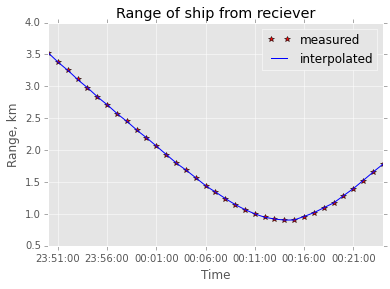

In [10]:
_ = plt.plot(sourceRange.index, sourceRange, 'r*',\
             label='measured')
_ = plt.plot(simRange.index, simRange, 'b', label='interpolated')
_ = plt.title('Range of ship from reciever')
_ = plt.xlabel('Time')
_ = plt.ylabel('Range, km')
_ = plt.legend()
plt.savefig('figures_061215/range_source')

In [11]:
comparisonFrequency = 49
comparisonChannel = 2

In [12]:
enviornment = swellEx_env.loadEnviornment()
linearSourceScale = 10 ** (sourceLevel / 20)
p = []
v = []
for f in frequencies:
    nm = Chinook(f, enviornment)
    nm.calculateModes_eig(300, 10)
    p.append(np.squeeze(nm.calculatePressure(sD,\
        sensorPosition[comparisonChannel],\
        1e3 * np.array(simRange))) * linearSourceScale)
    v.append(np.squeeze(nm.calculatePressure(sD,\
        sensorPosition[comparisonChannel],\
        1e3 * np.array(simRange),\
        isPressure = False)) * linearSourceScale)

In [13]:
p = pd.DataFrame(np.array(p).T, index = simRange.index,\
                 columns = frequencies)
v = pd.DataFrame(np.array(v).T, index = simRange.index,\
                 columns = frequencies)

I_z = (1 / 2) * np.real(p * np.conj(v))
I_z_i = (1 / 2) * np.imag(p * np.conj(v))

I_z = pd.DataFrame(I_z, index = simRange, columns=frequencies)
I_z_i = pd.DataFrame(I_z_i, index = simRange, columns=frequencies)

plotRange = sourceRange.reindex(timeStamp)
plotRange = plotRange.interpolate()

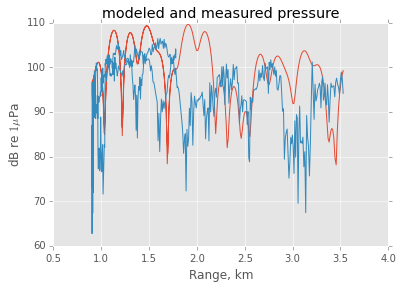

In [14]:
# TL plot for measured pressure
_ = plt.plot(simRange, 20 * np.log10(np.abs(\
        p[comparisonFrequency])))
_ = plt.plot(plotRange, 20 * np.log10(np.abs(\
        pressure[comparisonFrequency])))
_ = plt.xlabel('Range, km')
_ = plt.ylabel(r'dB re $1\mu$Pa')
_ = plt.title('modeled and measured pressure')
plt.savefig('figures/measuredTL')

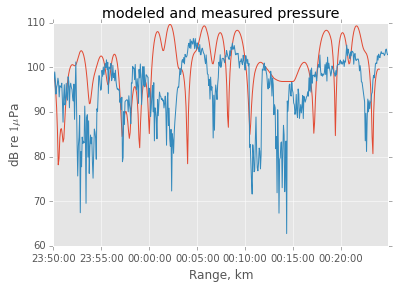

In [15]:
# TL plot for measured pressure
_ = plt.plot(simRange.index, 20 * np.log10(np.abs(\
        p[comparisonFrequency])))
_ = plt.plot(timeStamp, 20 * np.log10(np.abs(\
        pressure[comparisonFrequency])))
_ = plt.xlabel('Range, km')
_ = plt.ylabel(r'dB re $1\mu$Pa')
_ = plt.title('modeled and measured pressure')
plt.savefig('figures_061215/measuredTL')

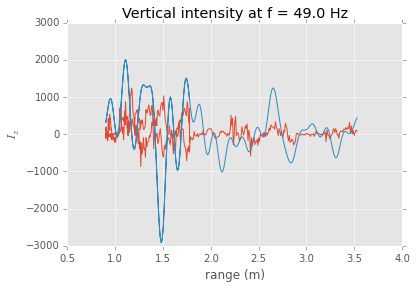

In [16]:
plotI = 0

_ = plt.plot(plotRange, np.real(intensity[comparisonFrequency]))
_ = plt.plot(simRange, I_z[comparisonFrequency])
_ = plt.xlabel('range (m)')
_ = plt.ylabel(r'$I_z$')
_ = plt.title('Vertical intensity at f = %.1f Hz'\
              %comparisonFrequency)
# _ = plt.ylim(-2e-8,2e-8)

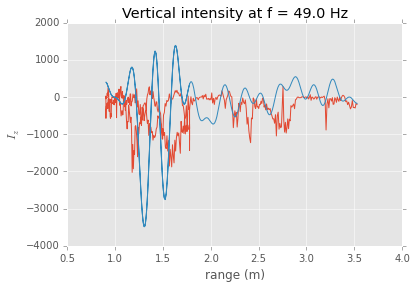

In [17]:
plotI = 0
plotRange = sourceRange.reindex(timeStamp)
plotRange = plotRange.interpolate()

_ = plt.plot(plotRange, np.imag(intensity[comparisonFrequency]))
_ = plt.plot(simRange, I_z_i[comparisonFrequency])
_ = plt.xlabel('range (m)')
_ = plt.ylabel(r'$I_z$')
_ = plt.title('Vertical intensity at f = %.1f Hz'\
              %comparisonFrequency)
# _ = plt.ylim(-2e-8,2e-8)

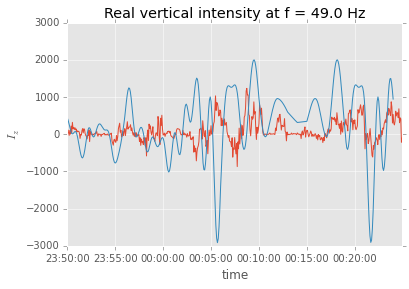

In [18]:
_ = plt.plot(timeStamp, np.real(intensity[comparisonFrequency]))
_ = plt.plot(simRange.index, I_z[comparisonFrequency])
_ = plt.xlabel('time')
_ = plt.ylabel(r'$I_z$')
_ = plt.title('Real vertical intensity at f = %.1f Hz'\
              %comparisonFrequency)
plt.savefig('figures_061215/measuredI_z')

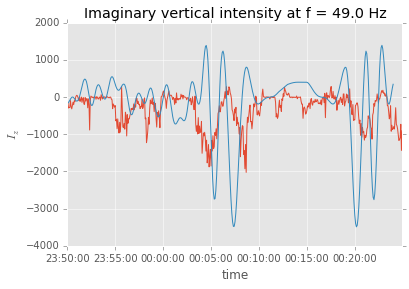

In [19]:
_ = plt.plot(timeStamp, np.imag(intensity[comparisonFrequency]))
_ = plt.plot(simRange.index, I_z_i[comparisonFrequency])
_ = plt.xlabel('time')
_ = plt.ylabel(r'$I_z$')
_ = plt.title('Imaginary vertical intensity at f = %.1f Hz'\
              %comparisonFrequency)
plt.savefig('figures_061215/measuredI_z_i')